In [1]:
%load_ext autoreload
%autoreload 2

from nca.models import BaselineNCA, FCInvAE
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from kornia import augmentation

from tqdm.auto import tqdm
import base64
import matplotlib
from io import BytesIO
from PIL import Image
from IPython.display import HTML

In [2]:
device = "cuda"
inv_ae = FCInvAE(msg_size=8, frame_size=32).to(device)

In [3]:
loss, info = inv_ae.optim_step(bs=32, noise_size=0.1, lr=0.01)

In [4]:
inv_ae = FCInvAE(msg_size=16, frame_size=64).to(device)
# inv_ae.fit(its=1000, bs=100, noise_size=1, lr=0.01)

In [5]:
# inv_ae.plot_loss()

In [6]:
out = inv_ae.forward(bs=5, noise_size=0.5)

In [7]:
# nca = BaselineNCA(lr=0.01).to(device)
# nca_out = nca.forward(out["image"], steps=10)
# out["image"] = nca_out[-1]
# nca_out = torch.stack(nca_out)[:,:,0]

In [8]:
def make_gif(nca_out, fps=10):
    seq_out = nca_out.detach().cpu().numpy()
    pil_arrs = (plt.cm.viridis(seq_out)[:,:,:,:3] * 255).astype(np.uint8)
    pils = [Image.fromarray(arr).resize((200, 200), Image.NEAREST) for arr in pil_arrs]
    
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [9]:
# make_gif(nca_out[:,3], fps=22)

In [10]:
# inv_ae.render_out(out)

In [11]:
noise_size = 1
noiser = nn.Sequential(
#     augmentation.RandomAffine(
#         degrees=(-0, 0), translate=(0.1, 0.1), scale=(1, 1), p=noise_size
#     ),
    # augmentation.RandomBoxBlur(kernel_size=(5, 5), p=noise_size),
    augmentation.RandomErasing((0.1, 0.2), (0.3, 1 / 0.3), p=noise_size),
    # augmentation.RandomJigsaw(grid=(4, 4), p=noise_size),
    augmentation.RandomGaussianNoise(1, 0.1, same_on_batch=False, p=noise_size),
)

In [12]:
inv_ae = FCInvAE(msg_size=16, frame_size=64).to(device)
nca = BaselineNCA().to(device)
lr = 0.001
optim = torch.optim.Adam(list(nca.parameters()) + list(inv_ae.parameters()), lr=lr)
history = []

bs = 100
steps = 100
its = 1000

pbar = tqdm(range(its))
for e in pbar:
    msg = inv_ae.sample_msg(bs)
    image = inv_ae.encode(msg)
    image_rep = image.repeat(1, 4, 1, 1)
    nca_out = nca.forward_many(image_rep, steps=steps // 2)
    nca_out = torch.stack(nca_out)

    last_frame = nca_out[-1]
    last_frame = noiser(last_frame)
    nca_out2 = nca.forward_many(last_frame, steps=steps // 2)
    nca_out2 = torch.stack(nca_out2)[:,:,:1]

    last_frame = nca_out2[-1]
    decode_inp = last_frame.reshape(bs, -1)
    decoded_msg = inv_ae.decode(decode_inp).reshape(bs, -1)

    loss = F.mse_loss(decoded_msg, msg)

    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.set_description(f"Loss: {loss.item():0.6f}")
    history.append(loss.item())
    break
    
nca_out_cat = torch.cat([nca_out[:,:,:1], nca_out2])

  0%|          | 0/1000 [00:00<?, ?it/s]

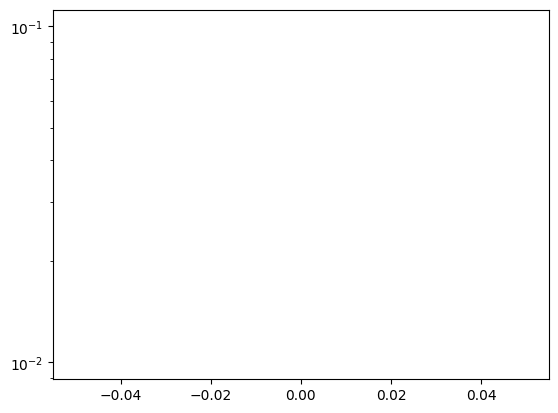

In [13]:
# plt.plot(history)
# plt.yscale('log')

In [14]:
# im = nca_out_cat[-1, 0, 0].detach().cpu().numpy()
# plt.imshow(im)

In [1]:
make_gif(nca_out_cat[:,4,0], fps=22)

NameError: name 'make_gif' is not defined

In [19]:
nca = BaselineNCA().to(device)

In [1]:
image_rep = inp = torch.randn(100, 4, 64, 64).to(device)
nca_out = nca.forward_many(image_rep, steps=100)
nca_out = torch.stack(nca_out)

In [ ]:
make_gif(nca_out[:,0,0], fps=22)